# ART decision tree classifier attack

This notebook shows how to compute adversarial examples on decision trees (as described in by Papernot et al. in https://arxiv.org/abs/1605.07277). Due to the structure of the decision tree, an adversarial example can be computed without any explicit gradients, only by traversing the learned tree structure.

Consider the following simple decision tree for four dimensional data, where we go to the left if a condition is true:

                    F1<3
           
              F2<5        F2>2
                
         F4>3     C1    F3<1     C3* 
             
      C1     C2       C3    C1  
      
Given sample [4,4,1,1], the tree outputs C3 (as indicated by the star). To misclassify the sample, we walk one node up and explore the subtree on the left. We find the leaf outputting C1 and change the two features, obtaining [4,1.9,0.9,1]. In this implementation, we change only the features with wrong values, and specify the offset in advance.

## Applying the attack

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

from art.attacks.evasion import DecisionTreeAttack
from art.estimators.classification import SklearnClassifier

In [11]:
digits = load_digits()
X = digits.data
y = digits.target

print(X.shape)
print(y.shape)
print(np.unique(y, return_counts=True))

(1797, 64)
(1797,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))


(14, 64)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3]
[0 1 2 3 4 5 6 7 8 9 0 1 2 3]


c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


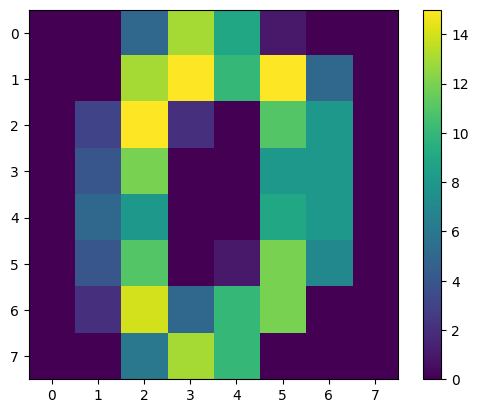

In [13]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
clf_art = SklearnClassifier(clf)
print(X[:14].shape)
print(clf.predict(X[:14]))
print(y[:14])

plt.imshow(X[0].reshape(8,8))
plt.colorbar()

We now craft adversarial examples and plot their classification. The difference is really small, and often only one or two features are changed.

Decision tree attack:   0%|          | 0/14 [00:00<?, ?it/s]

Orig: [0 1 2 3 4 5 6 7 8 9 0 1 2 3]
Pred: [2 4 4 6 0 4 8 2 4 4 2 4 6 4]


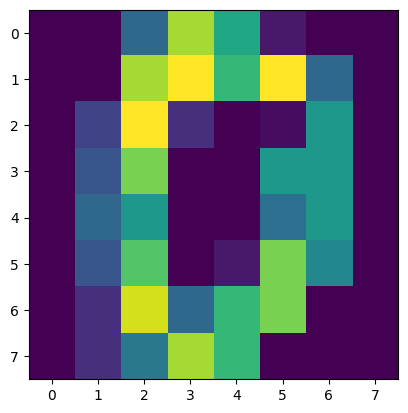

In [14]:
attack = DecisionTreeAttack(clf_art)
adv = attack.generate(X[:14])
print('Orig:', y[:14])
print('Pred:', clf.predict(adv))

plt.imshow(adv[0].reshape(8,8))
# plt.imshow((X[0]-adv[0]).reshape(8,8))  ##use this to plot the difference

The change is possibly larger if we specify which class the sample should be (mis-)classified as. To do this, we just specify a label for each attack point.

Decision tree attack:   0%|          | 0/14 [00:00<?, ?it/s]

[6 6 7 7 8 8 9 9 1 1 2 2 3 3]


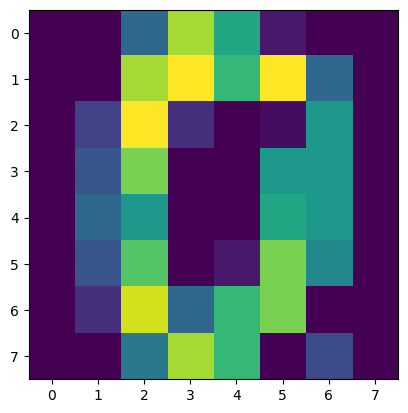

In [8]:
adv = attack.generate(X[:14],np.array([6,6,7,7,8,8,9,9,1,1,2,2,3,3]))
print(clf.predict(adv))
plt.imshow(adv[0].reshape(8,8))

Finally, the attack has an offset parameter which specifies how close the new value of the feature is compared to the learned threshold of the tree. The default value is very small (0.001), however the value can be set larger when desired. Setting it to a very large value might however yield adversarial examples outside the range or normal features!

Decision tree attack: 100%|██████████| 14/14 [00:00<00:00, 1586.65it/s]

[6 4 4 4 6 4 1 2 4 4 6 4 4 4]


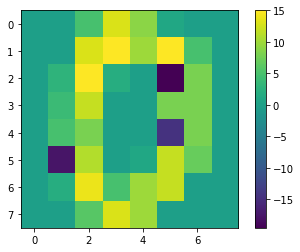

In [5]:
attack = DecisionTreeAttack(clf_art,offset=20.0)
adv = attack.generate(X[:14])
print(clf.predict(adv))
plt.imshow(adv[0].reshape(8,8))
plt.colorbar()